In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

# Import datasets

In [2]:
csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL3", "TSR_ALL3G_X_TRAIN.csv")
G_X_train = pd.read_csv(csv_path)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL3", "TSR_ALL3G_y_TRAIN.csv")
G_y_train = pd.read_csv(csv_path)
G_y_train = np.ravel(G_y_train)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL3", "TSR_ALL3G_X_TEST.csv")
G_X_test = pd.read_csv(csv_path)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL3", "TSR_ALL3G_y_TEST.csv")
G_y_test = pd.read_csv(csv_path)
G_y_test = np.ravel(G_y_test)

In [3]:
csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL3", "TSR_ALL3B_X_TRAIN.csv")
B_X_train = pd.read_csv(csv_path)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL3", "TSR_ALL3B_y_TRAIN.csv")
B_y_train = pd.read_csv(csv_path)
B_y_train = np.ravel(B_y_train)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL3", "TSR_ALL3B_X_TEST.csv")
B_X_test = pd.read_csv(csv_path)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL3", "TSR_ALL3B_y_TEST.csv")
B_y_test = pd.read_csv(csv_path)
B_y_test = np.ravel(B_y_test)

# GOOD when Discharge

## Algorithms

### Extra trees

In [4]:
pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3G_ET_BASED.pkl")
G_ET_BASED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3G_ET_TUNED.pkl")
G_ET_TUNED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3G_ET_CALIBRATED.pkl")
G_ET_CALIBRATED = joblib.load(pkl_path)

In [5]:
#BASED
G_y_test_pred = G_ET_BASED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc)

#TUNED
print('--> Tuned Parameters Best Score: ', G_ET_TUNED.best_score_)
print('--> Best Parameters: \n', G_ET_TUNED.best_params_)

G_y_test_pred = G_ET_TUNED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_tuned)

#CALIBRATED
G_y_test_pred = G_ET_CALIBRATED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_cc)

AUC of testing set: 0.6894865103022585
--> Tuned Parameters Best Score:  0.7328377408783334
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 150, 'extratreesclassifier__min_samples_split': 150, 'extratreesclassifier__max_samples': 0.8, 'extratreesclassifier__max_features': 0.2, 'extratreesclassifier__max_depth': 150, 'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__class_weight': {0: 24, 1: 1}, 'extratreesclassifier__bootstrap': True}
AUC of testing set: 0.7338766595975226
AUC of testing set: 0.7359737921671634


#### Selected Columns

In [6]:
etG_fi = G_ET_CALIBRATED.base_estimator._final_estimator.feature_importances_
etG_fi_df = pd.DataFrame(etG_fi)
etG_fi_df.index = G_X_test.columns
etG_fi_df.columns = (["Value"])
etG_fi_df = etG_fi_df.reset_index(drop=False)
etG_fi_df.columns = (["Feature","Value"])
etG_fi_df = etG_fi_df.sort_values(["Value"], ascending=False)

In [7]:
G_test_auroc_list = []
G_test_auroc_tuned_list = []
G_test_auroc_cc_list = []

for i in 10,20,30:
    etG_fi_index = etG_fi_df[0:i].index
    
    G_X_train_selected = G_X_train.iloc[:, etG_fi_index]
    
    G_X_test_selected = G_X_test.iloc[:, etG_fi_index]
    
    # base et_selected
    et_selected = ExtraTreesClassifier(random_state=19)
    G_ET_BASED_selected = et_selected.fit(G_X_train_selected, G_y_train)
    
    G_y_test_pred = G_ET_BASED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected = auc(fpr, tpr)
    G_test_auroc_list.append(G_test_auroc_selected)
    print('AUC of testing set:', G_test_auroc_selected)
    
    # tune et_selected   
    et_rscv_selected = G_ET_TUNED.best_estimator_
    G_ET_TUNED_selected = et_rscv_selected.fit(G_X_train_selected, G_y_train)

    G_y_test_pred = G_ET_TUNED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_tuned = auc(fpr, tpr)
    G_test_auroc_tuned_list.append(G_test_auroc_selected_tuned)
    print('AUC of testing set:', G_test_auroc_selected_tuned)

    # calibrate et_selected 
    et_cccv_selected = CalibratedClassifierCV(base_estimator=G_ET_TUNED_selected, cv=5)
    G_ET_CALIBRATED_selected = et_cccv_selected.fit(G_X_train_selected, G_y_train)

    G_y_test_pred = G_ET_CALIBRATED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_cc = auc(fpr, tpr)
    G_test_auroc_cc_list.append(G_test_auroc_selected_cc)
    print('AUC of testing set:', G_test_auroc_selected_cc)
    
G_test_auroc_list.append(G_test_auroc)
G_test_auroc_tuned_list.append(G_test_auroc_tuned)
G_test_auroc_cc_list.append(G_test_auroc_cc)

AUC of testing set: 0.5855114870078126
AUC of testing set: 0.7192228719838436
AUC of testing set: 0.7213119937937694
AUC of testing set: 0.658840294964605
AUC of testing set: 0.7368979808669328
AUC of testing set: 0.7381780159456279
AUC of testing set: 0.6782895763151349
AUC of testing set: 0.7295677141086343
AUC of testing set: 0.7301436455702607


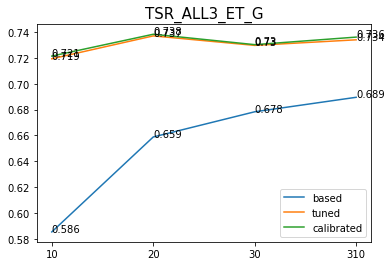

In [8]:
x = "10","20","30","310"
plt.plot(x, G_test_auroc_list, label = "based")
plt.plot(x, G_test_auroc_tuned_list, label = "tuned")
plt.plot(x, G_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(G_test_auroc_list[i],3), (x[i], G_test_auroc_list[i]))
    plt.annotate(round(G_test_auroc_tuned_list[i],3), (x[i], G_test_auroc_tuned_list[i]))
    plt.annotate(round(G_test_auroc_cc_list[i],3), (x[i], G_test_auroc_cc_list[i]))
plt.title('TSR_ALL3_ET_G', fontsize=15)
#plt.savefig('PLOT/TSR_ALL3/TSR_ALL3_ET_G.png')
plt.show()

## XGBClassifier

In [9]:
pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3G_XGBC_BASED.pkl")
G_XGBC_BASED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3G_XGBC_TUNED.pkl")
G_XGBC_TUNED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3G_XGBC_CALIBRATED.pkl")
G_XGBC_CALIBRATED = joblib.load(pkl_path)

In [10]:
#BASED
G_y_test_pred = G_XGBC_BASED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc)

#TUNED
print('--> Tuned Parameters Best Score: ', G_XGBC_TUNED.best_score_)
print('--> Best Parameters: \n', G_XGBC_TUNED.best_params_)

G_y_test_pred = G_XGBC_TUNED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_tuned)

#CALIBRATED
G_y_test_pred = G_XGBC_CALIBRATED.predict_proba(G_X_test)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_cc)

AUC of testing set: 0.6733418781436962
--> Tuned Parameters Best Score:  0.7318374052322674
--> Best Parameters: 
 {'xgbclassifier__subsample': 0.5, 'xgbclassifier__scale_pos_weight': 0.04, 'xgbclassifier__reg_lambda': 0.1, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__max_depth': 75, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__gamma': 1, 'xgbclassifier__colsample_bytree': 0.2}
AUC of testing set: 0.7371956438331907
AUC of testing set: 0.7456735573254181


### Selected Columns

In [11]:
xgbcG_fi = G_XGBC_CALIBRATED.base_estimator._final_estimator.feature_importances_
xgbcG_fi_df = pd.DataFrame(xgbcG_fi)
xgbcG_fi_df.index = G_X_test.columns
xgbcG_fi_df.columns = (["Value"])
xgbcG_fi_df = xgbcG_fi_df.reset_index(drop=False)
xgbcG_fi_df.columns = (["Feature","Value"])
xgbcG_fi_df = xgbcG_fi_df.sort_values(["Value"], ascending=False)

In [12]:
G_test_auroc_list = []
G_test_auroc_tuned_list = []
G_test_auroc_cc_list = []

for i in 10,20,30:
    xgbcG_fi_index = xgbcG_fi_df[0:i].index
    
    G_X_train_selected = G_X_train.iloc[:, xgbcG_fi_index]
    
    G_X_test_selected = G_X_test.iloc[:, xgbcG_fi_index]
    
    # base xgbc_selected
    xgbc_selected = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)
    G_XGBC_BASED_selected = xgbc_selected.fit(G_X_train_selected, G_y_train)
    
    G_y_test_pred = G_XGBC_BASED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected = auc(fpr, tpr)
    G_test_auroc_list.append(G_test_auroc_selected)
    print('AUC of testing set:', G_test_auroc_selected)

    # tune xgbc_selected
    xgbcG_rscv_selected = G_XGBC_TUNED.best_estimator_
    G_XGBC_TUNED_selected = xgbcG_rscv_selected.fit(G_X_train_selected, G_y_train)

    G_y_test_pred = G_XGBC_TUNED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_tuned = auc(fpr, tpr)
    G_test_auroc_tuned_list.append(G_test_auroc_selected_tuned)
    print('AUC of testing set:', G_test_auroc_selected_tuned)

    # calibrate xgbc_selected
    xgbcG_cccv_selected = CalibratedClassifierCV(base_estimator=G_XGBC_TUNED_selected, cv=5)
    G_XGBC_CALIBRATED_selected = xgbcG_cccv_selected.fit(G_X_train_selected, G_y_train)

    G_y_test_pred = G_XGBC_CALIBRATED_selected.predict_proba(G_X_test_selected)
    fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
    G_test_auroc_selected_cc = auc(fpr, tpr)
    G_test_auroc_cc_list.append(G_test_auroc_selected_cc)
    print('AUC of testing set:', G_test_auroc_selected_cc)
    
G_test_auroc_list.append(G_test_auroc)
G_test_auroc_tuned_list.append(G_test_auroc_tuned)
G_test_auroc_cc_list.append(G_test_auroc_cc)

AUC of testing set: 0.684103279773675
AUC of testing set: 0.7141254990914112
AUC of testing set: 0.717155252739469
AUC of testing set: 0.6685371087903331
AUC of testing set: 0.7208018348855938
AUC of testing set: 0.7218626281194531
AUC of testing set: 0.6760162070317606
AUC of testing set: 0.7257297169672107
AUC of testing set: 0.7286068445617482


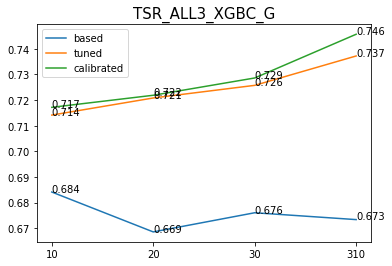

In [13]:
x = "10","20","30","310"
plt.plot(x, G_test_auroc_list, label = "based")
plt.plot(x, G_test_auroc_tuned_list, label = "tuned")
plt.plot(x, G_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(G_test_auroc_list[i],3), (x[i], G_test_auroc_list[i]))
    plt.annotate(round(G_test_auroc_tuned_list[i],3), (x[i], G_test_auroc_tuned_list[i]))
    plt.annotate(round(G_test_auroc_cc_list[i],3), (x[i], G_test_auroc_cc_list[i]))
plt.title('TSR_ALL3_XGBC_G', fontsize=15)
#plt.savefig('PLOT/TSR_ALL3/TSR_ALL3_XGBC_G.png')
plt.show()

# BAD when Discharge

## Algorithms

## Extra trees

In [14]:
pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3B_ET_BASED.pkl")
B_ET_BASED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3B_ET_TUNED.pkl")
B_ET_TUNED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3B_ET_CALIBRATED.pkl")
B_ET_CALIBRATED = joblib.load(pkl_path)

In [15]:
### BASED ET
B_y_test_pred = B_ET_BASED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc)

### TUNED ET
print('--> Tuned Parameters Best Score: ', B_ET_TUNED.best_score_)
print('--> Best Parameters: \n', B_ET_TUNED.best_params_)

B_y_test_pred = B_ET_TUNED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_tuned)

### CALIBRATED ET
B_y_test_pred = B_ET_CALIBRATED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_cc)

AUC of testing set: 0.8567415706122674
--> Tuned Parameters Best Score:  0.8595910093391377
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 150, 'extratreesclassifier__min_samples_split': 25, 'extratreesclassifier__max_samples': 0.8, 'extratreesclassifier__max_features': 0.8, 'extratreesclassifier__max_depth': 75, 'extratreesclassifier__criterion': 'entropy', 'extratreesclassifier__class_weight': 'balanced', 'extratreesclassifier__bootstrap': True}
AUC of testing set: 0.8620997509874587
AUC of testing set: 0.8631041628713277


### Selected Columns

In [16]:
etB_fi = B_ET_CALIBRATED.base_estimator._final_estimator.feature_importances_
etB_fi_df = pd.DataFrame(etB_fi)
etB_fi_df.index = B_X_test.columns
etB_fi_df.columns = (["Value"])
etB_fi_df = etB_fi_df.reset_index(drop=False)
etB_fi_df.columns = (["Feature","Value"])
etB_fi_df = etB_fi_df.sort_values(["Value"], ascending=False)

In [17]:
B_test_auroc_list = []
B_test_auroc_tuned_list = []
B_test_auroc_cc_list = []

for i in 10,20,30:
    etB_fi_index = etB_fi_df[0:i].index
    
    B_X_train_selected = B_X_train.iloc[:, etB_fi_index]
    
    B_X_test_selected = B_X_test.iloc[:, etB_fi_index]
    
    # base et_selected
    et_selected = ExtraTreesClassifier(random_state=19)
    B_ET_BASED_selected = et_selected.fit(B_X_train_selected, B_y_train)
    
    B_y_test_pred = B_ET_BASED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected = auc(fpr, tpr)
    B_test_auroc_list.append(B_test_auroc_selected)
    print('AUC of testing set:', B_test_auroc_selected)
    
    # tune et_selected   
    et_rscv_selected = B_ET_TUNED.best_estimator_
    B_ET_TUNED_selected = et_rscv_selected.fit(B_X_train_selected, B_y_train)

    B_y_test_pred = B_ET_TUNED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_tuned = auc(fpr, tpr)
    B_test_auroc_tuned_list.append(B_test_auroc_selected_tuned)
    print('AUC of testing set:', B_test_auroc_selected_tuned)

    # calibrate et_selected 
    et_cccv_selected = CalibratedClassifierCV(base_estimator=B_ET_TUNED_selected, cv=5)
    B_ET_CALIBRATED_selected = et_cccv_selected.fit(B_X_train_selected, B_y_train)

    B_y_test_pred = B_ET_CALIBRATED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_cc = auc(fpr, tpr)
    B_test_auroc_cc_list.append(B_test_auroc_selected_cc)
    print('AUC of testing set:', B_test_auroc_selected_cc)
    
B_test_auroc_list.append(B_test_auroc)
B_test_auroc_tuned_list.append(B_test_auroc_tuned)
B_test_auroc_cc_list.append(B_test_auroc_cc)

AUC of testing set: 0.7410811213092783
AUC of testing set: 0.8429383422419634
AUC of testing set: 0.8450084421745524
AUC of testing set: 0.839379296155966
AUC of testing set: 0.859503739210941
AUC of testing set: 0.8606141811291825
AUC of testing set: 0.8540304056209136
AUC of testing set: 0.8635927917966659
AUC of testing set: 0.8638139032098079


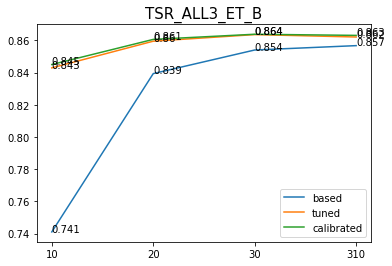

In [18]:
x = "10","20","30","310"
plt.plot(x, B_test_auroc_list, label = "based")
plt.plot(x, B_test_auroc_tuned_list, label = "tuned")
plt.plot(x, B_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(B_test_auroc_list[i],3), (x[i], B_test_auroc_list[i]))
    plt.annotate(round(B_test_auroc_tuned_list[i],3), (x[i], B_test_auroc_tuned_list[i]))
    plt.annotate(round(B_test_auroc_cc_list[i],3), (x[i], B_test_auroc_cc_list[i]))
plt.title('TSR_ALL3_ET_B', fontsize=15)
#plt.savefig('PLOT/TSR_ALL3/TSR_ALL3_ET_B.png')
plt.show()

## XGBClassifier

In [19]:
pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3B_XGBC_BASED.pkl")
B_XGBC_BASED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3B_XGBC_TUNED.pkl")
B_XGBC_TUNED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "TSR_ALL3B_XGBC_CALIBRATED.pkl")
B_XGBC_CALIBRATED = joblib.load(pkl_path)

In [20]:
### BASED XGBC
B_y_test_pred = B_XGBC_BASED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc)

### TUNED XGBC
print("--> Tuned Parameters Best Score: ", B_XGBC_TUNED.best_score_)
print("--> Best Parameters: \n", B_XGBC_TUNED.best_params_)

B_y_test_pred = B_XGBC_TUNED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_tuned)

### CALIBRATED XGBC
B_y_test_pred = B_XGBC_CALIBRATED.predict_proba(B_X_test)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_cc)

AUC of testing set: 0.8519405507699964
--> Tuned Parameters Best Score:  0.8650149939025866
--> Best Parameters: 
 {'xgbclassifier__subsample': 0.5, 'xgbclassifier__scale_pos_weight': 3, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 10, 'xgbclassifier__n_estimators': 75, 'xgbclassifier__max_depth': 25, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 10, 'xgbclassifier__colsample_bytree': 0.8}
AUC of testing set: 0.8695435478856348
AUC of testing set: 0.8681303887825396


### Selected Columns

In [21]:
xgbcB_fi = B_XGBC_CALIBRATED.base_estimator._final_estimator.feature_importances_
xgbcB_fi_df = pd.DataFrame(xgbcB_fi)
xgbcB_fi_df.index = B_X_test.columns
xgbcB_fi_df.columns = (["Value"])
xgbcB_fi_df = xgbcB_fi_df.reset_index(drop=False)
xgbcB_fi_df.columns = (["Feature","Value"])
xgbcB_fi_df = xgbcB_fi_df.sort_values(["Value"], ascending=False)

In [22]:
B_test_auroc_list = []
B_test_auroc_tuned_list = []
B_test_auroc_cc_list = []

for i in 10,20,30:
    xgbcB_fi_index = xgbcB_fi_df[0:i].index
    
    B_X_train_selected = B_X_train.iloc[:, xgbcB_fi_index]
    
    B_X_test_selected = B_X_test.iloc[:, xgbcB_fi_index]
    
    # base xgbc_selected
    xgbc_selected = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)
    B_XGBC_BASED_selected = xgbc_selected.fit(B_X_train_selected, B_y_train)
    
    B_y_test_pred = B_XGBC_BASED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected = auc(fpr, tpr)
    B_test_auroc_list.append(B_test_auroc_selected)
    print('AUC of testing set:', B_test_auroc_selected)

    # tune xgbc_selected
    xgbcB_rscv_selected = B_XGBC_TUNED.best_estimator_
    B_XGBC_TUNED_selected = xgbcB_rscv_selected.fit(B_X_train_selected, B_y_train)

    B_y_test_pred = B_XGBC_TUNED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_tuned = auc(fpr, tpr)
    B_test_auroc_tuned_list.append(B_test_auroc_selected_tuned)
    print('AUC of testing set:', B_test_auroc_selected_tuned)

    # calibrate xgbc_selected
    xgbcB_cccv_selected = CalibratedClassifierCV(base_estimator=B_XGBC_TUNED_selected, cv=5)
    B_XGBC_CALIBRATED_selected = xgbcB_cccv_selected.fit(B_X_train_selected, B_y_train)

    B_y_test_pred = B_XGBC_CALIBRATED_selected.predict_proba(B_X_test_selected)
    fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
    B_test_auroc_selected_cc = auc(fpr, tpr)
    B_test_auroc_cc_list.append(B_test_auroc_selected_cc)
    print('AUC of testing set:', B_test_auroc_selected_cc)
    
B_test_auroc_list.append(B_test_auroc)
B_test_auroc_tuned_list.append(B_test_auroc_tuned)
B_test_auroc_cc_list.append(B_test_auroc_cc)

AUC of testing set: 0.8374104850773503
AUC of testing set: 0.846116800846861
AUC of testing set: 0.8461907919955083
AUC of testing set: 0.8443188877708004
AUC of testing set: 0.856057403913514
AUC of testing set: 0.8563823184429619
AUC of testing set: 0.8517155602092557
AUC of testing set: 0.864814866962478
AUC of testing set: 0.8657776139276916


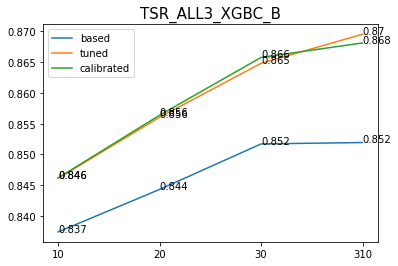

In [23]:
x = "10","20","30","310"
plt.plot(x, B_test_auroc_list, label = "based")
plt.plot(x, B_test_auroc_tuned_list, label = "tuned")
plt.plot(x, B_test_auroc_cc_list, label = "calibrated")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(B_test_auroc_list[i],3), (x[i], B_test_auroc_list[i]))
    plt.annotate(round(B_test_auroc_tuned_list[i],3), (x[i], B_test_auroc_tuned_list[i]))
    plt.annotate(round(B_test_auroc_cc_list[i],3), (x[i], B_test_auroc_cc_list[i]))
plt.title('TSR_ALL3_XGBC_B', fontsize=15)
#plt.savefig('PLOT/TSR_ALL3/TSR_ALL3_XGBC_B.png')
plt.show()